This is taken from an analysis by Taylor Gowan of the 2020 Labor Day wind event in Oregon.

## Get the right chunk

We use the HRRR Zarr chunk index file to find the grid point nearest to the Horse Creek Station (ID: HSFO3) (44.940806 N, 122.400806 W), downwind of the Beechie Creek Fire. 

In [ ]:
# It's an h5 file so we have to download it rather than opening it from the cloud.
! wget "https://hrrrzarr.s3.amazonaws.com/grid/HRRR_chunk_index.h5"

In [3]:
%%time
import xarray as xr
import cartopy.crs as ccrs

chunk_index = xr.open_dataset("HRRR_chunk_index.h5", engine="scipy")
projection = ccrs.LambertConformal(central_longitude=-97.5,
                             central_latitude=38.5,
                             standard_parallels=[38.5])

def get_nearest_point(projection, chunk_index, longitude, latitude):
    x, y = projection.transform_point(longitude, latitude, ccrs.PlateCarree())
    return chunk_index.sel(x=x, y=y, method="nearest")

nearest_point = get_nearest_point(projection, chunk_index, -122.4008, 44.9408)
chunk_id = nearest_point.chunk_id.values
print(chunk_id)

5.1
CPU times: user 946 ms, sys: 255 ms, total: 1.2 s
Wall time: 1.55 s


## Calculate climatologies

For every grid point in the chunk, we calculate the 95th percentile of wind gusts for the month of September, using data from 2017-2019. \[TODO update when 2016 is available\]

First, we need some code for accessing the data. Since libraries such as zarr and xarray don't support accessing a single chunk of a zarr array, this involves fairly low-level stuff like handling decompression.

In [72]:
import dataclasses
import datetime
import numcodecs as ncd
import numpy as np
import boto3
from botocore import UNSIGNED
from botocore.config import Config

s3 = boto3.resource(service_name='s3', region_name='us-west-1', config=Config(signature_version=UNSIGNED))


@dataclasses.dataclass
class ZarrId:
    run_hour: datetime.datetime
    level_type: str
    var_level: str
    var_name: str
    model_type: str
        
    def format_chunk_id(self, chunk_id):
        return f"0.{chunk_id}" if self.model_type == "fcst" else chunk_id
        

def create_s3_chunk_url(zarr_id, chunk_id, prefix=False):
    url = zarr_id.run_hour.strftime(
        f"{zarr_id.level_type}/%Y%m%d/%Y%m%d_%Hz_{zarr_id.model_type}.zarr/")
    url += f"{zarr_id.var_level}/{zarr_id.var_name}/{zarr_id.var_level}/{zarr_id.var_name}/"
    url += f"{zarr_id.format_chunk_id(chunk_id)}"
    return url


def retrieve_object(s3, s3_url):
    obj = s3.Object('hrrrzarr', s3_url)
    return obj.get()['Body'].read()


def decompress_chunk(zarr_id, compressed_data):
    buffer = ncd.blosc.decompress(compressed_data)
    
    dtype = "<f2"
    if zarr_id.var_level == "surface" and zarr_id.var_name == "PRES":
        dtype = "<f4"
        
    chunk = np.frombuffer(buffer, dtype=dtype)
    
    if zarr_id.model_type == "anl":
        data_array = np.reshape(chunk, (150, 150))
    else:
        entry_size = 22500
        data_array = np.reshape(chunk, (len(chunk)//entry_size, 150, 150))
        
    return data_array


def get_chunk(zid, chunk_id):
    return decompress_chunk(zid, retrieve_object(s3, create_s3_chunk_url(zid, chunk_id)))

Now we need to get the variable of interest for all hours of September for each year.

In [73]:
%%time
from pandas import date_range

dates = []
for year in range(2017, 2020): # should be 2016 but the data isn't quite available yet
    dates += [hour.to_pydatetime() for hour in date_range(start=f"{year}-09-01",end=f"{year}-10-01",
                                                 freq="H", closed="left")]
    
zids = [ZarrId(
                run_hour=date,
                level_type="sfc",
                var_level="surface",
                var_name="GUST",
                model_type="anl"
            ) 
        for date in dates]

gust_array = np.array([get_chunk(zid, chunk_id) for zid in zids])

CPU times: user 11.2 s, sys: 573 ms, total: 11.8 s
Wall time: 2min 8s


Calculate the 95th percentile at every grid point.

In [14]:
%%time
percentile_95 = np.percentile(gust_array, 95, axis=0)

CPU times: user 1.33 s, sys: 11.9 ms, total: 1.35 s
Wall time: 1.35 s


In [15]:
%%time
print(np.mean(percentile_95))

10.586304123263883
CPU times: user 280 µs, sys: 137 µs, total: 417 µs
Wall time: 326 µs


## Compare to Labor Day gust estimates and forecasts

Now, we look at the difference between the gusts at 12z on 2020-09-08 and the 95th percentile climatology we just calculated. We do this using the analysis (F00) data and the predictions from 3 prior forecasts.

Defining the information we want to collect:

In [20]:
from collections import namedtuple

comparison_anl_zid = ZarrId(
                run_hour=datetime.datetime(2020, 9, 8, 12),
                level_type="sfc",
                var_level="surface",
                var_name="GUST",
                model_type="anl"
            ) 

ComparisonForecast = namedtuple("ComparisonForecast", ["day", "hour", "lead_time"])
comparison_fcsts = [ComparisonForecast(8, 0, 12),
                    ComparisonForecast(7, 18, 18),
                    ComparisonForecast(7, 12, 24)]

comparison_fcst_zids = [
    ZarrId(
                run_hour=datetime.datetime(2020, 9, fcst.day, fcst.hour),
                level_type="sfc",
                var_level="surface",
                var_name="GUST",
                model_type="fcst"
            ) 
    for fcst in comparison_fcsts
]

Retrieving the comparison data and doing the diff:

In [21]:
%%time

diff_anl = get_chunk(comparison_anl_zid, chunk_id) - percentile_95
diff_fcsts = [
    get_chunk(zid, chunk_id)[fcst.lead_time - 1, :, :] - percentile_95
    for fcst, zid in zip(comparison_fcsts, comparison_fcst_zids)
]

CPU times: user 46 ms, sys: 14.4 ms, total: 60.3 ms
Wall time: 669 ms


## Plot it

We'll plot the climatology and the diffs.

First, some plot style/setup code:

In [77]:
import cartopy
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.dates import DateFormatter
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def get_plot(clevs=np.arange(9, 19.01, 1), subplot=None):
    if subplot is None:
        ax = plt.axes(projection=ccrs.Mercator())
    else:
        ax = plt.subplot(subplot, projection=ccrs.Mercator())

    ax.coastlines(linewidth=1.5)
    ax.set_extent([-124.65,-119.98,42.1,45.9])
    states = cartopy.feature.NaturalEarthFeature(
                category='cultural', scale='50m', facecolor='none',
                name='admin_1_states_provinces_shp')

    roads = cartopy.feature.NaturalEarthFeature(
                category='cultural', scale='10m', facecolor='none',
                name='roads')
    
    if subplot != 224: # last one has no labels       
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
        
        gl.xlines = False
        gl.bottom_labels = False
        
        gl.ylines = False
        gl.right_labels = False

        size = 20 if subplot is None else 16
        if subplot is None or subplot in {221, 222}: # Top
            gl.xlocator = mticker.FixedLocator([-123,-121])
            gl.xformatter = LONGITUDE_FORMATTER
            gl.xlabel_style = {'size': size,'color': 'black'}
        else:
            gl.top_labels = False

        if subplot is None or subplot in {221, 223}: # Bottom
            gl.ylocator = mticker.FixedLocator([43,45])
            gl.yformatter = LATITUDE_FORMATTER
            gl.ylabel_style = {'size': size, 'color': 'black'}
        else:
            gl.left_labels = False

    cmap = plt.cm.get_cmap('plasma')
    norm = mcolors.BoundaryNorm(clevs,cmap.N)

    ax.add_feature(states,edgecolor='black',linewidth=1.5,zorder=98)
    ax.add_feature(roads,edgecolor='white',linewidth=1.5,zorder=98)
    ax.add_feature(cartopy.feature.BORDERS,edgecolor='black',zorder=98)
    return ax, clevs, cmap, norm


def post_process_plot(cs):
    ax.text(0.05, .93, '95th Percentile', transform=ax.transAxes, 
    size=20, bbox=dict(facecolor='white', edgecolor='black'),zorder=99)

    cb_ax = fig.add_axes([.205,.01,.62,.72],visible=None)
    cbar = plt.colorbar(cs, ax=cb_ax, ticks=[10,12,14,16,18], orientation='horizontal')
    cbar.ax.set_xticklabels(['10','12','14','16','18'], fontsize=15)
    cbar.set_label('Wind Gust (m/s)',size=20)
    
    
def add_subplot(subplot_number, data, text):
    ax, clevs, cmap, norm = get_plot(clevs=np.arange(-1, 30.1, 2.5), subplot=subplot_number)
    cs = ax.contourf(subgrid.longitude, subgrid.latitude, data, clevs, cmap=cmap,
                norm=norm, transform=ccrs.PlateCarree(), zorder=97, extend='both')
    ax.text(0.83, .85, text, transform=ax.transAxes, ha='center',
            size=15, bbox=dict(facecolor='white',edgecolor='black'),zorder=99)
    return cs


def post_process_plot_with_subplots(cs):
    cb_ax = fig.add_axes([.205, .05, .62, .72], visible=None)
    cbar = plt.colorbar(cs, ax=cb_ax, ticks=[0, 5, 10, 15, 20, 25, 30], orientation='horizontal', shrink=1.25)
    cbar.ax.set_xticklabels(['0','5','10','15','25','30'], fontsize=15)
    cbar.set_label('HRRR - 95th Percentile (m/s)', size=18)

    plt.subplots_adjust(wspace=0.03, hspace=-0.2)

Now, we plot the wind gust 95th percentile:

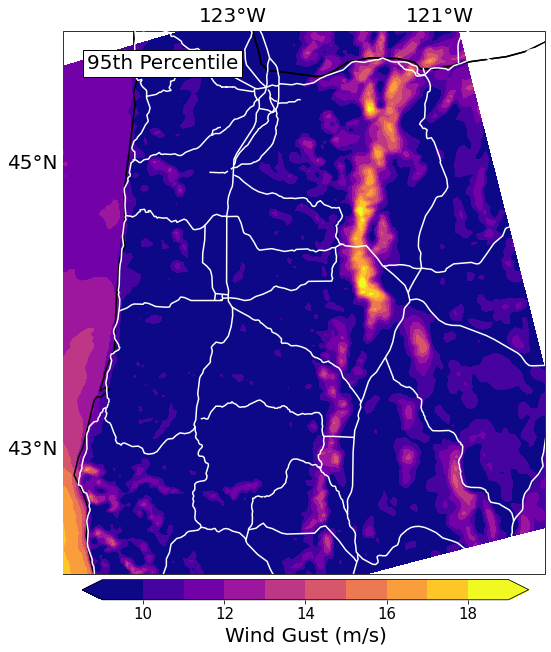

In [78]:
subgrid = chunk_index.where(lambda x: x.chunk_id==chunk_id, drop=True)

fig = plt.figure(figsize=(10,10))
ax, clevs, cmap, norm = get_plot()
cs = ax.contourf(subgrid.longitude, subgrid.latitude, percentile_95, clevs, cmap=cmap,
                norm=norm, transform=ccrs.PlateCarree(), zorder=97, extend='both')
post_process_plot(cs)
plt.show()
plt.close()

Now, we plot the comparisons:

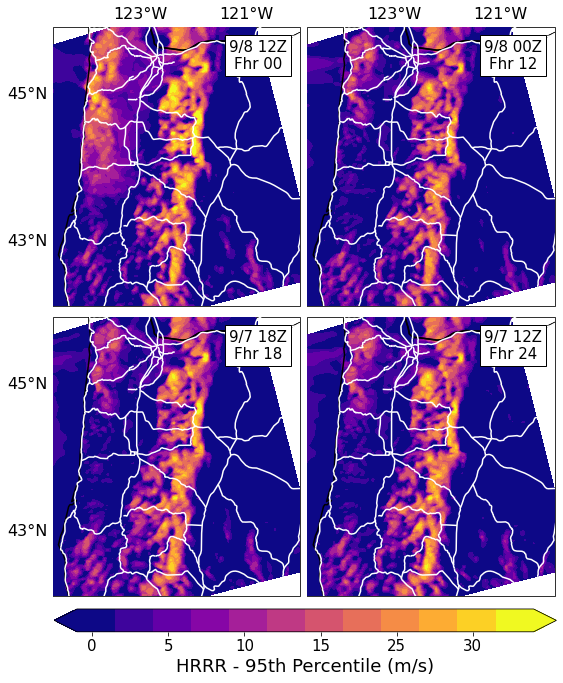

In [76]:
fig = plt.figure(figsize=(9,12))
    
cs = add_subplot(221, diff_anl, "9/8 12Z\nFhr 00")

fcst_labels = [f"9/{fcst.day} {str(fcst.hour).zfill(2)}Z\nFhr {fcst.lead_time}" 
               for fcst in comparison_fcsts]
for idx, (fcst_label, fcst_diff) in enumerate(zip(fcst_labels, diff_fcsts)):
    cs = add_subplot(222 + idx, fcst_diff, fcst_label)

post_process_plot_with_subplots(cs)

plt.show()
plt.close()